In [1]:
from tqdm import tqdm
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft
from ava.models.vae_dataset import get_syllable_partition
from ava.models.vae_dataset import get_syllable_data_loaders

In [2]:
split = 0.8 # 80/20 train/test split
days = [36, 37, 38, 139, 140]

# Construct a random train/test partition.
spec_dirs = ['../audio_spec/%d' % _ for _ in days]
partition = get_syllable_partition(spec_dirs, split)
# clip_dirs = ['../audio_clips/%d' % _ for _ in days]
# partition = get_syllable_partition(clip_dirs, split)

# Make Dataloaders.
loaders = get_syllable_data_loaders(partition, batch_size=128)

In [3]:
len(loaders['train'])

454

In [4]:
for i, spec in enumerate(loaders['test']):
    # spec = spec[:,:,5:-5]
    print(spec.shape)
    break # just to get a slice
sample = spec.numpy()

torch.Size([128, 50, 20])


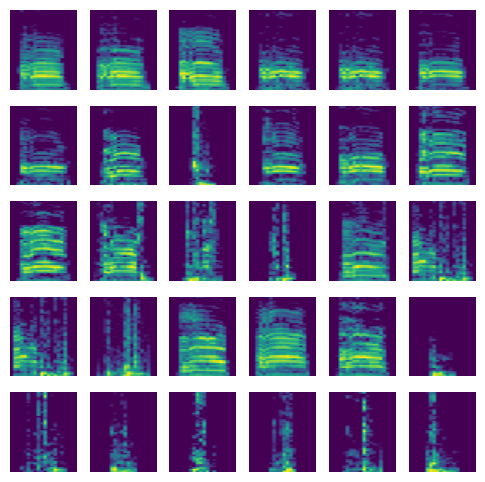

In [5]:
%matplotlib inline
fig, ax = plt.subplots(5, 6, figsize=(6,6), sharex='all', sharey='all')
ax = ax.flatten()
for i in range(len(ax)):
    ax[i].imshow(sample[i], aspect='auto', origin='lower')
    # # ax[i].plot(sample[i].numpy())
    # f, t, sxx = stft(sample[i].numpy(), fs=8820, nperseg=128, noverlap=64)
    # sxx = np.log(np.abs(sxx) + 1e-12)
    # sxx = (sxx - 3) / 5
    # sxx = np.clip(sxx, 0, 1)
    # ax[i].imshow(sxx, aspect='auto')
    ax[i].set_axis_off()
plt.show()

In [6]:
# act_func = lambda x: torch.log(1+x**2)
act_func = lambda x: torch.tanh(x)
class audioNet(nn.Module):
    def __init__(self, output_dim, kernel_dims, pad_dims):
        super(audioNet, self).__init__()
        self.w1 = nn.Conv2d(in_channels=1, out_channels=output_dim, 
                            kernel_size=kernel_dims, padding=pad_dims, 
                            bias=False)
        
    def forward(self, x):
        x = torch.unsqueeze(x, dim=1) # first dim is batch
        y = act_func(self.w1(x))
        return y

In [26]:
net = audioNet(100, (sample.shape[1],3), (0,1))
# optimizer = torch.optim.SGD(net.parameters(), lr=1e-2, weight_decay=1e-5)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-5)

EPOCH = 25
train_loss, test_loss = [], []

In [27]:
def loss_func(out):
    L2_sample = torch.sqrt((out**2).sum(dim=(0,2,3), keepdim=True))
    out = out / L2_sample
    L2_feature = torch.sqrt((out**2).sum(dim=1, keepdim=True))
    out = out / L2_feature
    L1_all = torch.abs(out).mean()
    return L1_all

In [28]:
for epoch in range(EPOCH):
    aux_train_loss = []
    for spec in tqdm(loaders['train']):
        # spec = spec[:,:,5:-5]
        spec += torch.normal(0, 0.05, size=spec.shape)
        spec = (spec - spec.mean(dim=(1,2), keepdim=True))
        optimizer.zero_grad()
        out = net(spec)
        loss = loss_func(out)
        
        aux_train_loss.append(loss.item())
        
        loss.backward()
        optimizer.step()
    
    train_loss.append(aux_train_loss)
    
    with torch.no_grad():
        aux_test_loss = []
        for i, spec in enumerate(loaders['test']):
            # spec = spec[:,:,5:-5]
            spec = (spec - spec.mean(dim=(1,2), keepdim=True))
            # spec = (spec - spec.mean(dim=(1,2), keepdim=True)) \
            #      / spec.std(dim=(1,2), keepdim=True)
            if i > 50:
                break
            out = net(spec)
            loss = loss_func(out)
            aux_test_loss.append(loss.item())
        test_loss.append(aux_test_loss)
    
    print('[%d] Train loss = %.3E, Test loss = %.3E' % \
          (epoch, np.mean(aux_train_loss), np.mean(aux_test_loss)))

100%|█████████████████████████████████████████| 454/454 [00:06<00:00, 67.66it/s]


[0] Train loss = 7.621E-02, Test loss = 6.735E-02


100%|█████████████████████████████████████████| 454/454 [00:05<00:00, 78.53it/s]


[1] Train loss = 7.167E-02, Test loss = 6.417E-02


100%|█████████████████████████████████████████| 454/454 [00:05<00:00, 84.50it/s]


[2] Train loss = 6.941E-02, Test loss = 6.237E-02


100%|█████████████████████████████████████████| 454/454 [00:05<00:00, 84.77it/s]


[3] Train loss = 6.787E-02, Test loss = 6.086E-02


100%|█████████████████████████████████████████| 454/454 [00:05<00:00, 82.93it/s]


[4] Train loss = 6.681E-02, Test loss = 5.968E-02


100%|█████████████████████████████████████████| 454/454 [00:05<00:00, 82.43it/s]


[5] Train loss = 6.614E-02, Test loss = 5.912E-02


100%|█████████████████████████████████████████| 454/454 [00:05<00:00, 81.49it/s]


[6] Train loss = 6.575E-02, Test loss = 5.871E-02


100%|█████████████████████████████████████████| 454/454 [00:05<00:00, 81.29it/s]


[7] Train loss = 6.544E-02, Test loss = 5.817E-02


100%|█████████████████████████████████████████| 454/454 [00:05<00:00, 82.00it/s]


[8] Train loss = 6.524E-02, Test loss = 5.815E-02


100%|█████████████████████████████████████████| 454/454 [00:05<00:00, 80.62it/s]


[9] Train loss = 6.507E-02, Test loss = 5.768E-02


100%|█████████████████████████████████████████| 454/454 [00:05<00:00, 77.91it/s]


[10] Train loss = 6.498E-02, Test loss = 5.743E-02


100%|█████████████████████████████████████████| 454/454 [00:05<00:00, 80.26it/s]


[11] Train loss = 6.492E-02, Test loss = 5.744E-02


100%|█████████████████████████████████████████| 454/454 [00:05<00:00, 80.75it/s]


[12] Train loss = 6.487E-02, Test loss = 5.730E-02


100%|█████████████████████████████████████████| 454/454 [00:05<00:00, 80.17it/s]


[13] Train loss = 6.483E-02, Test loss = 5.737E-02


100%|█████████████████████████████████████████| 454/454 [00:05<00:00, 80.04it/s]


[14] Train loss = 6.480E-02, Test loss = 5.715E-02


100%|█████████████████████████████████████████| 454/454 [00:05<00:00, 81.11it/s]


[15] Train loss = 6.469E-02, Test loss = 5.727E-02


100%|█████████████████████████████████████████| 454/454 [00:05<00:00, 81.27it/s]


[16] Train loss = 6.468E-02, Test loss = 5.694E-02


100%|█████████████████████████████████████████| 454/454 [00:05<00:00, 79.75it/s]


[17] Train loss = 6.465E-02, Test loss = 5.681E-02


100%|█████████████████████████████████████████| 454/454 [00:05<00:00, 80.97it/s]


[18] Train loss = 6.457E-02, Test loss = 5.751E-02


100%|█████████████████████████████████████████| 454/454 [00:05<00:00, 78.40it/s]


[19] Train loss = 6.458E-02, Test loss = 5.713E-02


100%|█████████████████████████████████████████| 454/454 [00:05<00:00, 78.43it/s]


[20] Train loss = 6.457E-02, Test loss = 5.687E-02


100%|█████████████████████████████████████████| 454/454 [00:05<00:00, 78.42it/s]


[21] Train loss = 6.459E-02, Test loss = 5.662E-02


100%|█████████████████████████████████████████| 454/454 [00:06<00:00, 74.68it/s]


[22] Train loss = 6.454E-02, Test loss = 5.662E-02


100%|█████████████████████████████████████████| 454/454 [00:06<00:00, 67.89it/s]


[23] Train loss = 6.455E-02, Test loss = 5.666E-02


100%|█████████████████████████████████████████| 454/454 [00:06<00:00, 73.76it/s]


[24] Train loss = 6.454E-02, Test loss = 5.673E-02


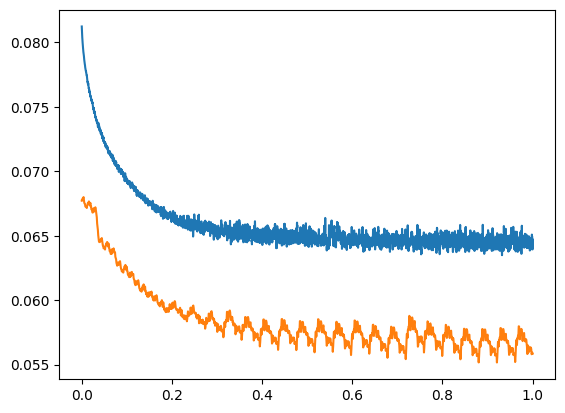

In [29]:
%matplotlib inline
train_loss, test_loss = np.hstack(train_loss), np.hstack(test_loss)
train_loss = np.convolve(train_loss, np.ones(10)/10)[11:-11]
test_loss = np.convolve(test_loss, np.ones(10)/10)[11:-11]
plt.plot(np.linspace(0,1,num=len(train_loss)), train_loss)
plt.plot(np.linspace(0,1,num=len(test_loss)), test_loss)

In [30]:
# torch.save(net.state_dict(), 'net_params.pkl')

In [31]:
# %matplotlib inline
# f, t, sxx = stft(spec[i].numpy(), fs=8820, nperseg=128, noverlap=64)
# sxx = np.log(np.abs(sxx) + 1e-12)
# sxx = (sxx - 3) / 5
# sxx = np.clip(sxx, 0, 1)
# plt.imshow(sxx)
# plt.colorbar()
# plt.show()

-0.2630337 0.22882272


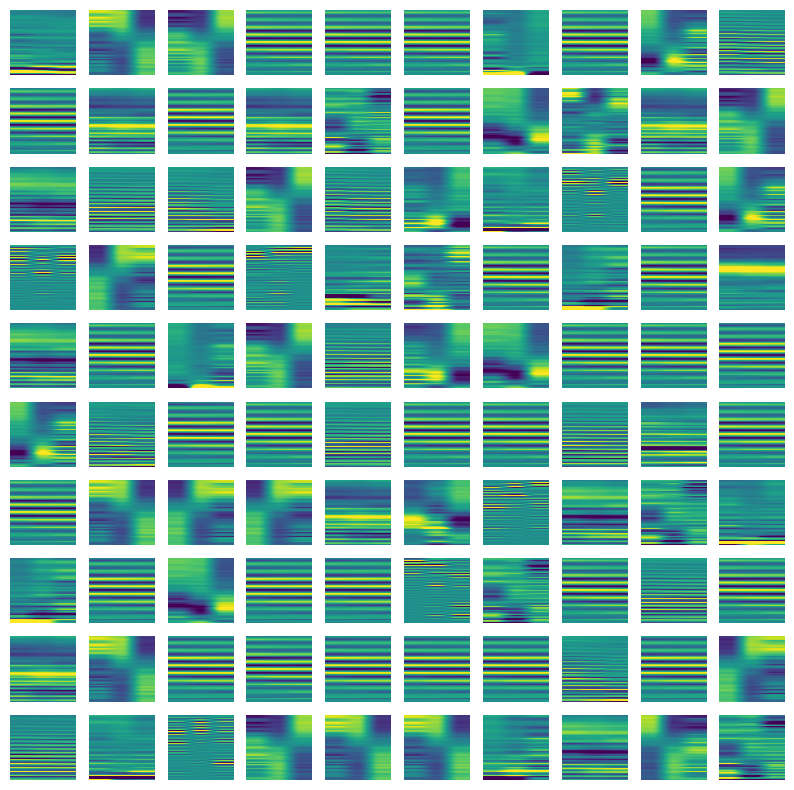

In [32]:
%matplotlib inline
fig, ax = plt.subplots(10, 10, figsize=(10,10), sharex='all', sharey='all')
ax = ax.flatten()
w1 = np.squeeze(net.w1.weight.data.numpy())
print(w1.min(), w1.max())
w1 = (w1 - w1.mean(axis=1)[:,None]) / w1.std(axis=1)[:,None]
for i in range(len(ax)):
    ax[i].imshow(w1[i], vmin=-2, vmax=2, 
                 aspect='auto', origin='lower')
    ax[i].set_axis_off()
plt.show()

0.05956217274069786
(128, 100, 20)


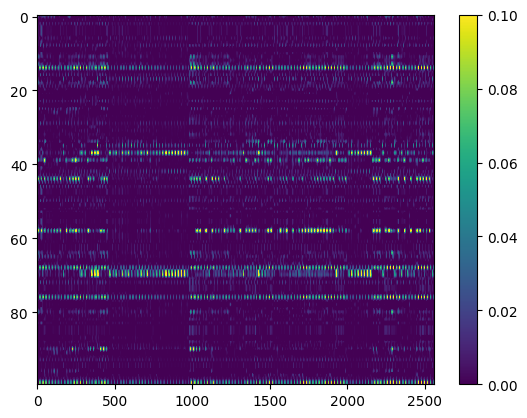

In [33]:
y = net(torch.tensor(sample - sample.mean(axis=(1,2),keepdims=True))).detach()
print(loss_func(y).item())
y = np.squeeze(y.numpy())
print(y.shape)
y = np.hstack(y)
plt.imshow(y, vmin=0, vmax=0.1, aspect='auto')
plt.colorbar()

In [34]:
# %matplotlib inline
# fig, ax = plt.subplots(5, 6, figsize=(10,10), sharex='all', sharey='all')
# ax = ax.flatten()
# w2 = net.w2.weight.data.numpy()
# w = w2 @ w1
# for i in range(len(ax)):
#     ax[i].imshow(w[i].reshape((64,32)), aspect='auto')
#     ax[i].set_axis_off()
# plt.show()